## 1.Installing Packages

In [42]:
#!pip install tensorflow tensorflow-gpu opencv-python matplotlib

#### 1.1 import packages

In [144]:
import tensorflow as tf
import os
import cv2
import imghdr
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [2]:
#To Avoid OOM errors by setting GPU Memory Consumption Growth (if you have NVIDIA graphic card)

# gpus  = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)

## 2.Remove dodgy images from dataset

In [3]:
data_dir = 'data'

In [4]:
#working with OS

# os.listdir(data_dir)
# os.listdir(os.path.join(data_dir, 'happy'))

In [5]:
#working with OpenCv

# img = cv2.imread(os.path.join('data', 'happy', '154006829.jpg'))
# img.shape
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# plt.show()

In [6]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [13]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print(f'Image Not In EXT List {image_path}')
                os.remove(image_path)
        except Exception as e:
            print(f'Issue With Image {image_path}')

Image Not In EXT List data\sad\4b8f0ef1-0d49-42f5-8984-4b3ebdfa46bd.webp
Image Not In EXT List data\sad\631f7194e1474f56957c1c745900dda9.webp
Image Not In EXT List data\sad\c20021a9841241f1a7324b945a7358b6.webp
Image Not In EXT List data\sad\depressed-and-sad-young-black-090023947_prevstill.jpeg
Image Not In EXT List data\sad\f6e1c0fd26cc7448ffa05c96dc9a655a596bbe00_2000x2000.webp
Image Not In EXT List data\sad\htcfsp-3.jpg
Image Not In EXT List data\sad\sad-person-pictures-2100-x-1500-krgdgnf5bc8rq0i7.jpg
Image Not In EXT List data\sad\sad-person-pictures-2bnso9uiwlhrikrx.jpg
Image Not In EXT List data\sad\unhappy-frustrated-adult-african-american-260nw-2201004301.jpg
Image Not In EXT List data\sad\v4-460px-Make-a-Sad-Person-Happy-Step-1.jpg.webp
Image Not In EXT List data\sad\v4-460px-Make-a-Sad-Person-Happy-Step-3.jpg.webp


## 3.Load Data

In [10]:
#To load data we use tensorflow API
tf.data.Dataset??

In [58]:
data = tf.keras.utils.image_dataset_from_directory('data')
print(data)

Found 451 files belonging to 2 classes.
<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [37]:
data_iterator = data.as_numpy_iterator()
print(data_iterator)

In [38]:
#Images represented as numpy arrays
batch = data_iterator.next()
print(batch[0].shape)

(32, 256, 256, 3)


In [39]:
# class 1 = Sad / class 0 = Happy
batch[1]

array([1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 0])

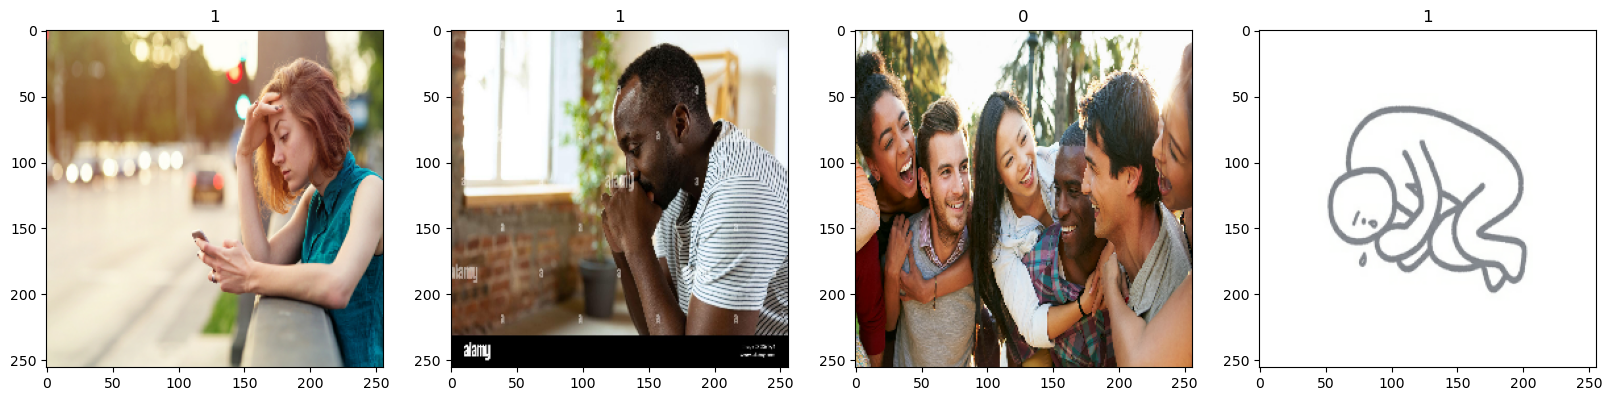

In [42]:
fig ,ax = plt.subplots(ncols = 4, figsize = (20, 20))
for i, img in enumerate(batch[0][:4]):
    ax[i].imshow(img.astype(int))
    ax[i].title.set_text(batch[1][i])

In [43]:
#If you want to use these data you can find Image min = 0.0 , max = 255 .So if you want to process data faster you should scaled data like below:

scaled = batch[0] / 255
scaled.min() # == 0.0
scaled.max() # == 1.0

1.0

## 4.Preprocess Data

#### 4.1 Scaled Data

In [59]:
data = data.map(lambda X, y: (X/255 , y))

In [60]:
scaled_iterator = data.as_numpy_iterator()

In [61]:
batch = scaled_iterator.next()
batch[0].max()

1.0

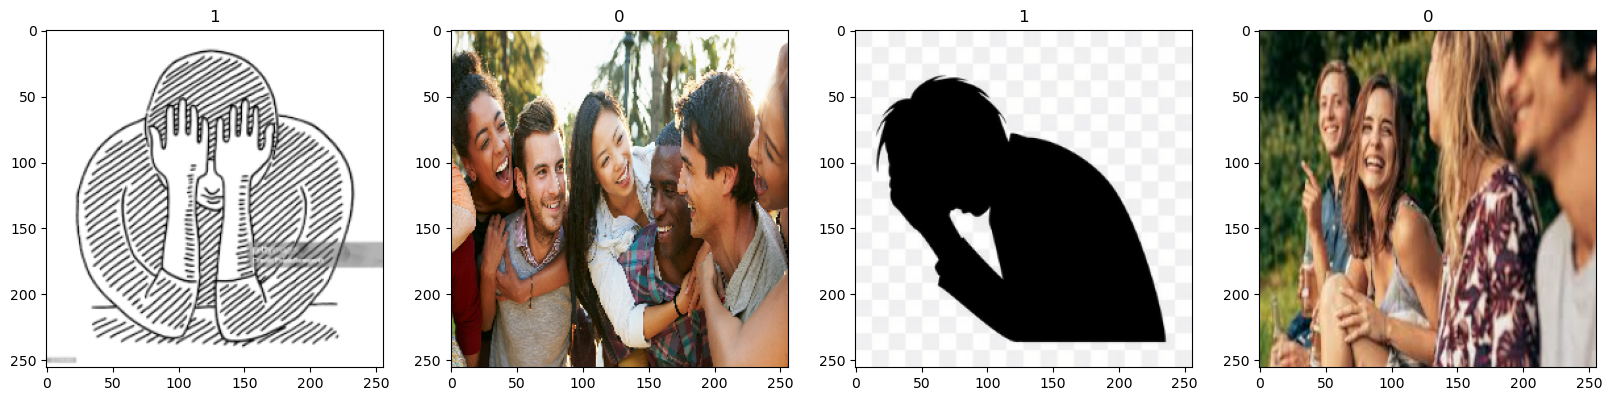

In [62]:
fig ,ax = plt.subplots(ncols = 4, figsize = (20, 20))
for i, img in enumerate(batch[0][:4]):
    ax[i].imshow(img)
    ax[i].title.set_text(batch[1][i])

#### 4.2 Split Data

In [64]:
len(data) #15 baches --> 32 images == 15 * 32 = 480 images (data)

15

In [71]:
train_size = int(len(data) * .7) 
cv_size = int(len(data) * .2)
test_size = int(len(data) * .1) + 1

print(f"train size is : {train_size}, cross validation size is : {cv_size}, test size is : {test_size}, all = 15")

train size is : 10, cross validation size is : 3, test size is : 2, all = 15


In [75]:
#Data categorization and segmentation.

train = data.take(train_size)
cv = data.skip(train_size).take(cv_size)
test = data.skip(train_size + cv_size).take(test_size)

## 5.Deep learning model

#### 5.1 Build Deep learning Model

In [105]:
model = Sequential()

In [106]:
model.add(Conv2D(16, (3,3), 1, activation = 'relu', input_shape = (256, 256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

In [107]:
model.compile('adam', loss = tf.losses.BinaryCrossentropy(), metrics = ['accuracy'])

In [108]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 30, 30, 16)      

#### 5.1 Train

In [109]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [110]:
hist = model.fit(train, epochs = 16, validation_data = cv, callbacks = [tensorboard_callback])

Epoch 1/16
10/10 [==============================] - 4s 296ms/step - loss: 0.7546 - accuracy: 0.4688 - val_loss: 0.6384 - val_accuracy: 0.5625
Epoch 2/16
10/10 [==============================] - 4s 289ms/step - loss: 0.5882 - accuracy: 0.6625 - val_loss: 0.5924 - val_accuracy: 0.7604
Epoch 3/16
10/10 [==============================] - 4s 293ms/step - loss: 0.5088 - accuracy: 0.7875 - val_loss: 0.4595 - val_accuracy: 0.7812
Epoch 4/16
10/10 [==============================] - 4s 304ms/step - loss: 0.4941 - accuracy: 0.7812 - val_loss: 0.4169 - val_accuracy: 0.8646
Epoch 5/16
10/10 [==============================] - 4s 299ms/step - loss: 0.4018 - accuracy: 0.8438 - val_loss: 0.4042 - val_accuracy: 0.8542
Epoch 6/16
10/10 [==============================] - 4s 301ms/step - loss: 0.3478 - accuracy: 0.8594 - val_loss: 0.3154 - val_accuracy: 0.8646
Epoch 7/16
10/10 [==============================] - 4s 287ms/step - loss: 0.2916 - accuracy: 0.9031 - val_loss: 0.2345 - val_accuracy: 0.9062
Epoch 

In [104]:
#You can see your model history by this expression 

hist.history

{'loss': [0.013389351777732372,
  0.013667525723576546,
  0.003979715518653393,
  0.006697304546833038,
  0.004465739708393812,
  0.006276740226894617,
  0.0013187035219743848,
  0.003450761316344142,
  0.006827657576650381,
  0.002009181072935462,
  0.005847891792654991,
  0.0005917908856645226,
  0.006529227830469608,
  0.0032230920623987913,
  0.007913229987025261,
  0.0007480768254026771],
 'accuracy': [0.9937499761581421,
  0.9937499761581421,
  1.0,
  0.996874988079071,
  0.996874988079071,
  0.996874988079071,
  1.0,
  0.996874988079071,
  0.996874988079071,
  1.0,
  0.9937499761581421,
  1.0,
  0.9937499761581421,
  0.996874988079071,
  0.996874988079071,
  1.0],
 'val_loss': [0.006815064232796431,
  0.014109383337199688,
  0.0038109447341412306,
  0.0010457104071974754,
  0.0019075991585850716,
  0.0026787705719470978,
  0.0005602026358246803,
  0.0007714017410762608,
  0.0010638950625434518,
  0.0007258325349539518,
  0.0006922946195118129,
  0.01528057362884283,
  0.01026886

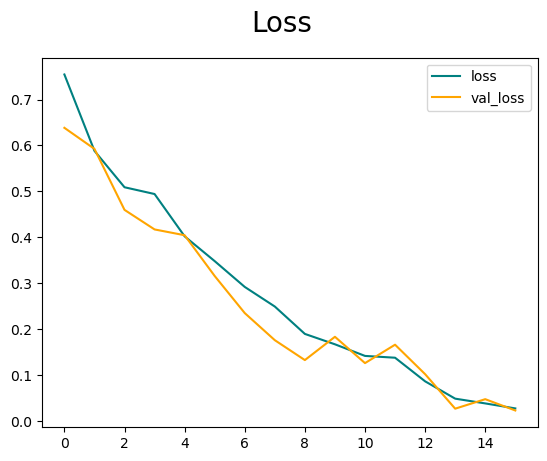

In [118]:
# Loss 

fig = plt.figure()
plt.plot(hist.history['loss'], color = 'teal', label = 'loss')
plt.plot(hist.history['val_loss'], color = 'orange', label = 'val_loss')
fig.suptitle("Loss", fontsize = 20)
plt.legend(loc = "upper right")
plt.show()

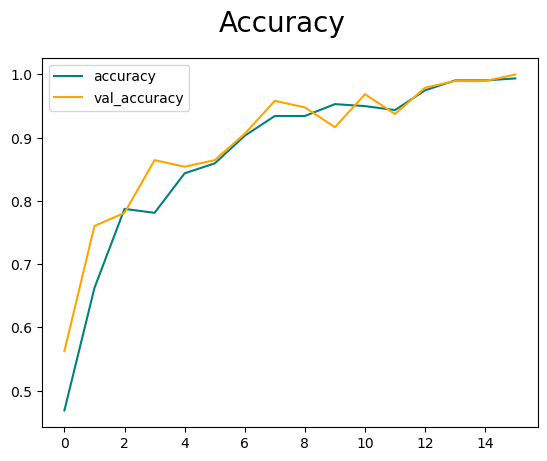

In [120]:
# Accuracy

fig = plt.figure()
plt.plot(hist.history['accuracy'], color = 'teal', label = 'accuracy')
plt.plot(hist.history['val_accuracy'], color = 'orange', label = 'val_accuracy')
plt.suptitle('Accuracy' , fontsize = 20)
plt.legend(loc = 'upper left')
plt.show()

## 6.Evaluate Performance

#### 6.1 Evaluate

In [122]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [123]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 85ms/step


In [124]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 1.0, Recall: 1.0, Accuracy: 1.0


#### 6.2 Testing

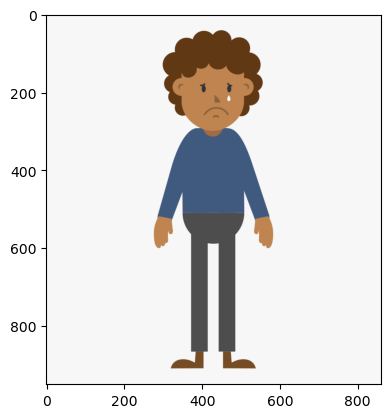

In [143]:
img = cv2.imread('sadtest.png') #you can test the diffrent images in order to test it!!!
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

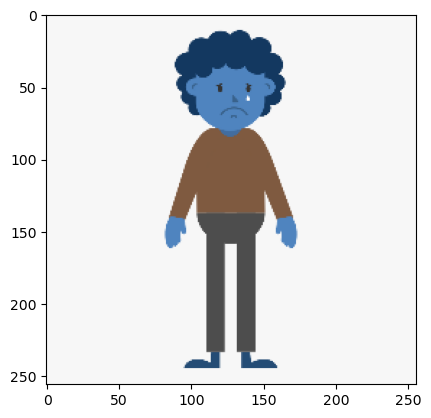

In [137]:
resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [138]:
resize.shape

TensorShape([256, 256, 3])

In [139]:
np.expand_dims(resize, 0).shape

(1, 256, 256, 3)

In [140]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 16ms/step


In [141]:
yhat

array([[0.78337985]], dtype=float32)

In [142]:
if yhat > 0.5:
    print(f'Predicted class is Sad : {yhat}')
else:
    print(f'Predicted class is Happy : {yhat}')

Predicted class is Sad : [[0.78337985]]


## Save & Lode The Model

#### Save Model

In [145]:
model.save(os.path.join('models', 'HappySadModelClassification.h5'))

#### Load Model

In [146]:
new_model = load_model(os.path.join('models', 'HappySadModelClassification.h5'))

In [148]:
yhat_new =  new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 17ms/step


In [149]:
if yhat_new > 0.5:
    print(f'Predicted class is Sad : {yhat_new}')
else:
    print(f'Predicted class is Happy : {yhat_new}')

Predicted class is Sad : [[0.78337985]]
